# Predicción de nacimientos en Colombia con Machine Learning (2020–2024)

**Actividad:** 5 – Predicción de nacimientos en Colombia con Machine Learning (Grupal)  
**Materia:** 2025-2_APLICACIONES I  
**Programa:** Maestría en Inteligencia Artificial  
**Institución:** Universidad de La Salle  

**Integrantes del grupo:**
- Jhon Barbosa – Grupo 1  
- Brayher Gómez – Grupo 2  

Este cuaderno presenta el desarrollo completo de la actividad, desde la recolección y preprocesamiento de los datos de nacimientos en Colombia (2020–2023), hasta la construcción, evaluación y aplicación de un modelo de Machine Learning para proyectar el número de nacimientos por departamento para el año 2024.


Actividad: **Predicción de nacimientos en Colombia con Machine Learning **

implementación de un flujo completo de Machine Learning para predecir el número de nacimientos por departamento en Colombia para el año **2024**, utilizando los datos históricos de nacimientos de los años **2020, 2021, 2022 y 2023** del DANE (Estadísticas Vitales – Nacimientos).




## A) Introducción

En este proyecto se construirá un modelo de **Machine Learning** para predecir el número de nacimientos por departamento en Colombia para el año **2024**.

### Objetivo general
Desarrollar un modelo de regresión supervisada que, a partir de los datos históricos de nacimientos por departamento entre 2020 y 2023, permita estimar el número de nacimientos por departamento para el año 2024.

### Tipo de problema
- Se trata de un problema de **regresión**, ya que la variable objetivo (número de nacimientos) es numérica continua.

### Fuente de datos
- Datos de nacimientos provenientes de las **Estadísticas Vitales – Nacimientos (EEVV)** del DANE para los años 2020, 2021, 2022 y 2023.


## B) Preprocesamiento de los datos

En esta sección se cargarán los archivos de nacimientos de cada año, se seleccionarán las columnas relevantes y se construirá un conjunto de datos agregado con el número de nacimientos por año y por departamento.

**Variables mínimas a utilizar:**
- `ANO` o `ANO_NAC` (año del nacimiento, el nombre puede variar según el archivo).
- `COD_DPTO` (código del departamento donde ocurre el nacimiento).



In [2]:
# === Importar librerías ===
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.float_format', lambda x: f'{x:,.0f}')


In [3]:
# === Achivos desde la ubicación del equipo ===
from google.colab import files

print('Sube los 4 archivos de nacimientos (2020, 2021, 2022 y 2023)...')
uploaded = files.upload()
list(uploaded.keys())

Sube los 4 archivos de nacimientos (2020, 2021, 2022 y 2023)...


Saving nac2022.xlsx to nac2022.xlsx
Saving BD-EEVV-Nacimientos-2023.xlsx to BD-EEVV-Nacimientos-2023.xlsx
Saving nac2021_excel.xlsx to nac2021_excel.xlsx
Saving nac2020_excel.xlsx to nac2020_excel.xlsx


['nac2022.xlsx',
 'BD-EEVV-Nacimientos-2023.xlsx',
 'nac2021_excel.xlsx',
 'nac2020_excel.xlsx']

In [4]:
# === Rutas de archivos y función de carga ===

files_paths = {
    2020: 'nac2020_excel.xlsx',
    2021: 'nac2021_excel.xlsx',
    2022: 'nac2022.xlsx',
    2023: 'BD-EEVV-Nacimientos-2023.xlsx'
}

files_paths


{2020: 'nac2020_excel.xlsx',
 2021: 'nac2021_excel.xlsx',
 2022: 'nac2022.xlsx',
 2023: 'BD-EEVV-Nacimientos-2023.xlsx'}

In [5]:
# === Función para cargar y agrupar los datos de un año ===
def cargar_y_agrupar(path, anio_esperado=None):
    """Carga un archivo de nacimientos y devuelve nacimientos agregados por año y departamento.

    Se asume que el archivo tiene al menos las columnas:
    - 'COD_DPTO': código del departamento
    - 'ANO' o 'ANO_NAC': año del nacimiento
    """
    # Intentamos leer columnas comunes. Ajusta la lista si en tu archivo cambian los nombres.
    posibles_columnas = ['COD_DPTO', 'ANO', 'ANO_NAC']
    df_raw = pd.read_excel(path)

    columnas_presentes = [c for c in posibles_columnas if c in df_raw.columns]
    print(f'Columnas encontradas en {path}:', columnas_presentes)

    # Renombrar columnas de año a un nombre estándar 'ANO'
    if 'ANO' not in df_raw.columns:
        if 'ANO_NAC' in df_raw.columns:
            df_raw = df_raw.rename(columns={'ANO_NAC': 'ANO'})
        else:
            raise ValueError('No se encontró una columna de año (ANO o ANO_NAC) en el archivo: ' + path)

    if 'COD_DPTO' not in df_raw.columns:
        raise ValueError('No se encontró la columna COD_DPTO en el archivo: ' + path)

    # Filtramos solo columnas necesarias
    df = df_raw[['COD_DPTO', 'ANO']].copy()

    # Si se espera un año específico, podemos forzar ese valor
    if anio_esperado is not None:
        df['ANO'] = anio_esperado

    # Agrupar por año y departamento
    agg = (
        df.groupby(['ANO', 'COD_DPTO'])
          .size()
          .reset_index(name='nacimientos')
    )
    return agg


In [6]:
# === DataFrame consolidado 2020–2023 ===
data_list = []

for anio, path in files_paths.items():
    print(f'Procesando año {anio} desde {path}...')
    agg_anio = cargar_y_agrupar(path, anio_esperado=anio)
    data_list.append(agg_anio)

df_nac = pd.concat(data_list, ignore_index=True)
df_nac = df_nac.rename(columns={'ANO': 'anio', 'COD_DPTO': 'depto'})

print('Dimensiones del DataFrame consolidado:', df_nac.shape)
df_nac.head()

Procesando año 2020 desde nac2020_excel.xlsx...
Columnas encontradas en nac2020_excel.xlsx: ['COD_DPTO', 'ANO']
Procesando año 2021 desde nac2021_excel.xlsx...
Columnas encontradas en nac2021_excel.xlsx: ['COD_DPTO', 'ANO']
Procesando año 2022 desde nac2022.xlsx...
Columnas encontradas en nac2022.xlsx: ['COD_DPTO', 'ANO']
Procesando año 2023 desde BD-EEVV-Nacimientos-2023.xlsx...
Columnas encontradas en BD-EEVV-Nacimientos-2023.xlsx: ['COD_DPTO', 'ANO']
Dimensiones del DataFrame consolidado: (132, 3)


,anio,depto,nacimientos
0,2020,5,71463
1,2020,8,41185
2,2020,11,92781
3,2020,13,33256
4,2020,15,13581


## C) Exploración de los datos

En esta sección se realiza un análisis exploratorio básico de los datos agregados:
- Evolución del número total de nacimientos a nivel nacional (2020–2023).
- Distribución de nacimientos por departamento para un año específico (por ejemplo, 2023).


In [7]:
# === Nacimientos totales por año (nivel nacional) ===
nac_nacional = (
    df_nac.groupby('anio')['nacimientos']
          .sum()
          .reset_index()
)
nac_nacional

,anio,nacimientos
0,2020,629402
1,2021,616914
2,2022,573625
3,2023,515549


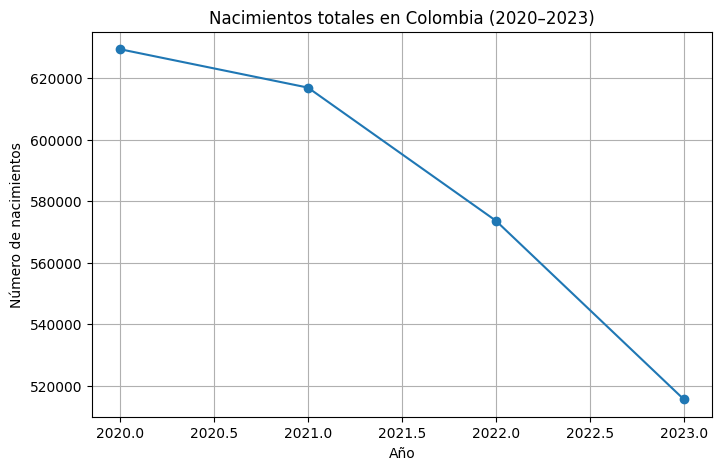

In [8]:
# === Gráfico de línea: tendencia nacional 2020–2023 ===
plt.figure(figsize=(8, 5))
plt.plot(nac_nacional['anio'], nac_nacional['nacimientos'], marker='o')
plt.title('Nacimientos totales en Colombia (2020–2023)')
plt.xlabel('Año')
plt.ylabel('Número de nacimientos')
plt.grid(True)
plt.show()

In [9]:
# === Nacimientos por departamento para 2023 ===
nac_2023 = df_nac[df_nac['anio'] == 2023].copy()
nac_2023 = nac_2023.sort_values('nacimientos', ascending=False)
nac_2023.head()

,anio,depto,nacimientos
101,2023,11,74286
99,2023,5,59311
122,2023,76,38397
100,2023,8,32872
102,2023,13,28222


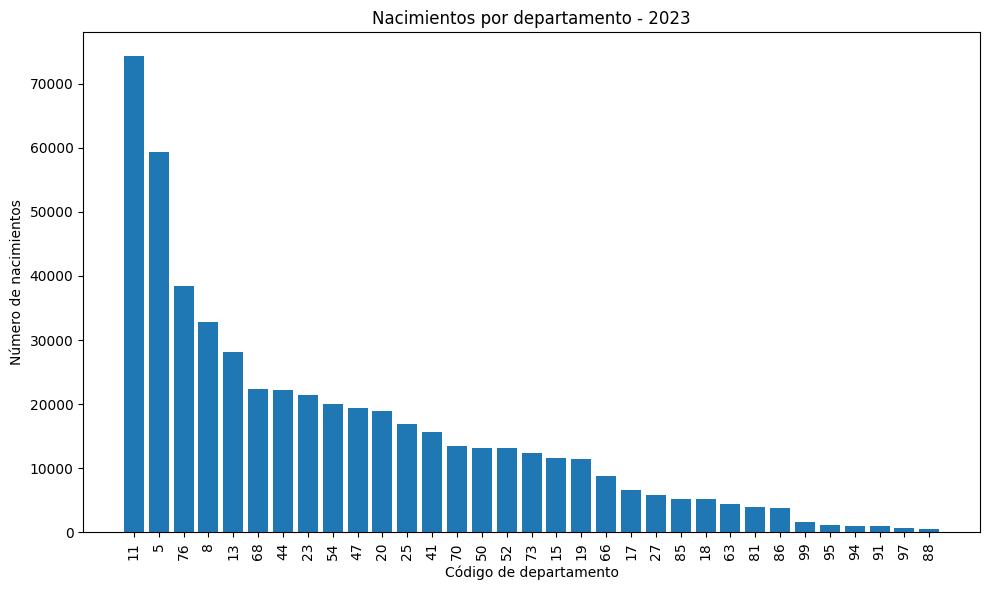

In [10]:
# === Gráfico de barras: nacimientos por departamento (2023) ===
plt.figure(figsize=(10, 6))
plt.bar(nac_2023['depto'].astype(str), nac_2023['nacimientos'])
plt.xticks(rotation=90)
plt.title('Nacimientos por departamento - 2023')
plt.xlabel('Código de departamento')
plt.ylabel('Número de nacimientos')
plt.tight_layout()
plt.show()

## D) Selección del modelo

Para este problema de regresión se evaluarán dos algoritmos de Machine Learning:

1. **Regresión lineal**.
2. **Random Forest Regressor**.

La variable objetivo será el número de nacimientos (`nacimientos`) y las variables de entrada serán:
- `anio` (numérica).
- `depto` (codificada mediante variables *one-hot*).

Se entrenarán los modelos con los datos de 2020–2022 y se evaluarán con los datos de 2023.

In [11]:
# === Preparación variables de entrada (X) y salida (y) ===
df_modelo = df_nac.copy()

# Codificación one-hot para el departamento
X_depto = pd.get_dummies(df_modelo['depto'].astype(str), prefix='depto')

# Matriz de características
X = pd.concat([df_modelo[['anio']], X_depto], axis=1)

# Variable objetivo
y = df_modelo['nacimientos']

X.shape, y.shape

((132, 34), (132,))

In [12]:
# === Separa datos de entrenamiento (2020–2022) y prueba (2023) ===
train_mask = df_modelo['anio'] < 2023
test_mask = df_modelo['anio'] == 2023

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

X_train.shape, X_test.shape

((99, 34), (33, 34))

In [15]:
# === Entrena y evalua los modelos ===
modelos = {
    'Regresión lineal': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42)
}

resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse_best = mean_squared_error(y_test, y_pred)
    rmse = mse_best ** 0.5
    r2 = r2_score(y_test, y_pred)

    resultados.append({
        'Modelo': nombre,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

df_resultados = pd.DataFrame(resultados)
df_resultados

,Modelo,MAE,RMSE,R2
0,Regresión lineal,"1,894","2,760",1
1,Random Forest,"1,518","2,025",1


## E) Entrenamiento del modelo

En esta sección se selecciona automáticamente el modelo con mejor desempeño según el **R²** sobre el conjunto de prueba (año 2023) y se analiza su rendimiento.

In [16]:
# === Selecciona el mejor modelo según R2 ===
best_idx = df_resultados['R2'].idxmax()
best_model_name = df_resultados.loc[best_idx, 'Modelo']
best_model = modelos[best_model_name]

print('Mejor modelo según R2:', best_model_name)
df_resultados

Mejor modelo según R2: Random Forest


,Modelo,MAE,RMSE,R2
0,Regresión lineal,"1,894","2,760",1
1,Random Forest,"1,518","2,025",1


In [18]:
# === Evaluación detallada del mejor modelo en 2023 ===
y_pred_test = best_model.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_test)
mse_best = mean_squared_error(y_test, y_pred_test)
rmse_best = mse_best ** 0.5
r2_best = r2_score(y_test, y_pred_test)

print('Métricas del mejor modelo (año 2023):')
print('MAE :', mae_best)
print('RMSE:', rmse_best)
print('R2  :', r2_best)


Métricas del mejor modelo (año 2023):
MAE : 1517.7019696969694
RMSE: 2025.0860238404164
R2  : 0.9844069391827649


## F) Evaluación del modelo

Se analizan las métricas cuantitativas (MAE, RMSE y R²) y se compara gráficamente el número de nacimientos reales con los valores predichos por el modelo para el año 2023.

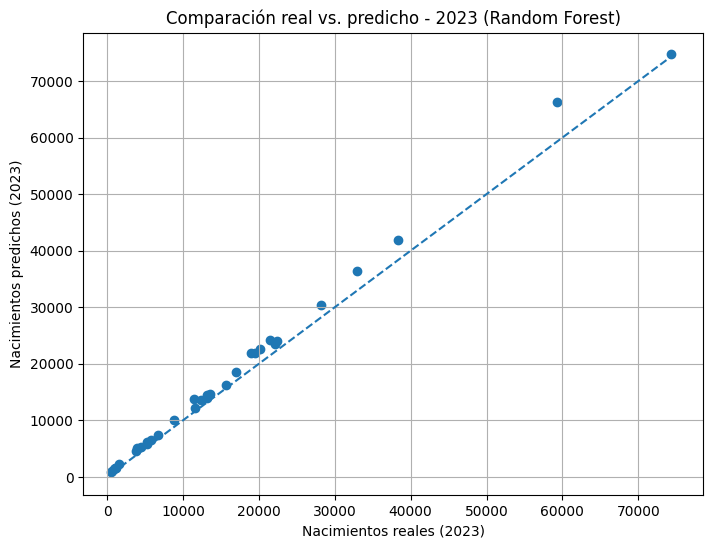

In [19]:
# === Comparación gráfica: valores reales vs. predichos (2023) ===
comparacion_2023 = df_modelo[test_mask][['depto', 'anio']].copy()
comparacion_2023['real'] = y_test.values
comparacion_2023['predicho'] = y_pred_test

plt.figure(figsize=(8, 6))
plt.scatter(comparacion_2023['real'], comparacion_2023['predicho'])
min_val = min(comparacion_2023['real'].min(), comparacion_2023['predicho'].min())
max_val = max(comparacion_2023['real'].max(), comparacion_2023['predicho'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')
plt.xlabel('Nacimientos reales (2023)')
plt.ylabel('Nacimientos predichos (2023)')
plt.title(f'Comparación real vs. predicho - 2023 ({best_model_name})')
plt.grid(True)
plt.show()


## G) Visualización de resultados y proyección 2024

En esta sección se entrena nuevamente el mejor modelo utilizando **todos los datos disponibles (2020–2023)** y se genera la proyección de nacimientos para el año **2024**:

- Se estima el número de nacimientos por departamento para 2024.
- Se calcula el total nacional estimado para 2024.
- Se generan los gráficos solicitados en la actividad:
  - Gráfico de líneas con la tendencia nacional 2020–2024.
  - Gráfico de barras con la estimación por departamento para 2024.


In [20]:
# === Prepara los conjuntos de datos para 2024 (todos los departamentos) ===
depts = df_modelo['depto'].unique()
df_2024 = pd.DataFrame({
    'anio': 2024,
    'depto': depts
})

# One-hot encoding para los departamentos de 2024
X_2024_depto = pd.get_dummies(df_2024['depto'].astype(str), prefix='depto')
X_2024 = pd.concat([df_2024[['anio']], X_2024_depto], axis=1)

# Asegurar que las columnas coincidan con las del modelo original
X_2024 = X_2024.reindex(columns=X.columns, fill_value=0)

X_2024.head()

,anio,depto_11,depto_13,depto_15,depto_17,depto_18,depto_19,depto_20,depto_23,depto_25,...,depto_8,depto_81,depto_85,depto_86,depto_88,depto_91,depto_94,depto_95,depto_97,depto_99
0,2024,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2024,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,2024,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2024,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2024,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [21]:
# === Reentrena el mejor modelo con todos los datos (2020–2023) ===
best_model.fit(X, y)

# Predicción de nacimientos por departamento para 2024
df_2024['nacimientos_predichos'] = best_model.predict(X_2024)
df_2024.head()

,anio,depto,nacimientos_predichos
0,2024,5,"61,239"
1,2024,8,"33,751"
2,2024,11,"74,837"
3,2024,13,"29,594"
4,2024,15,"11,603"


In [22]:
# === Total nacional estimado para 2024 ===
total_2024 = df_2024['nacimientos_predichos'].sum()
print('Número total de nacimientos estimado para 2024 (Colombia):')
total_2024

Número total de nacimientos estimado para 2024 (Colombia):


np.float64(530669.86)

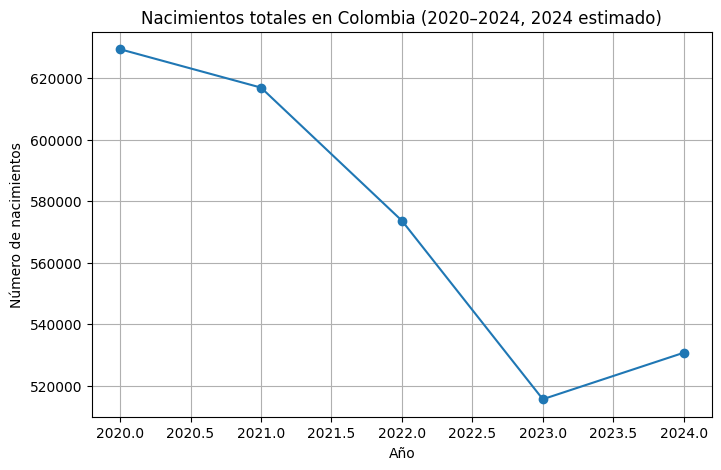

In [23]:
# === Gráfico de líneas: tendencia nacional 2020–2024 (incluyendo proyección) ===
nac_nacional_2024 = pd.concat([
    nac_nacional,
    pd.DataFrame({'anio': [2024], 'nacimientos': [total_2024]})
], ignore_index=True)

plt.figure(figsize=(8, 5))
plt.plot(nac_nacional_2024['anio'], nac_nacional_2024['nacimientos'], marker='o')
plt.title('Nacimientos totales en Colombia (2020–2024, 2024 estimado)')
plt.xlabel('Año')
plt.ylabel('Número de nacimientos')
plt.grid(True)
plt.show()

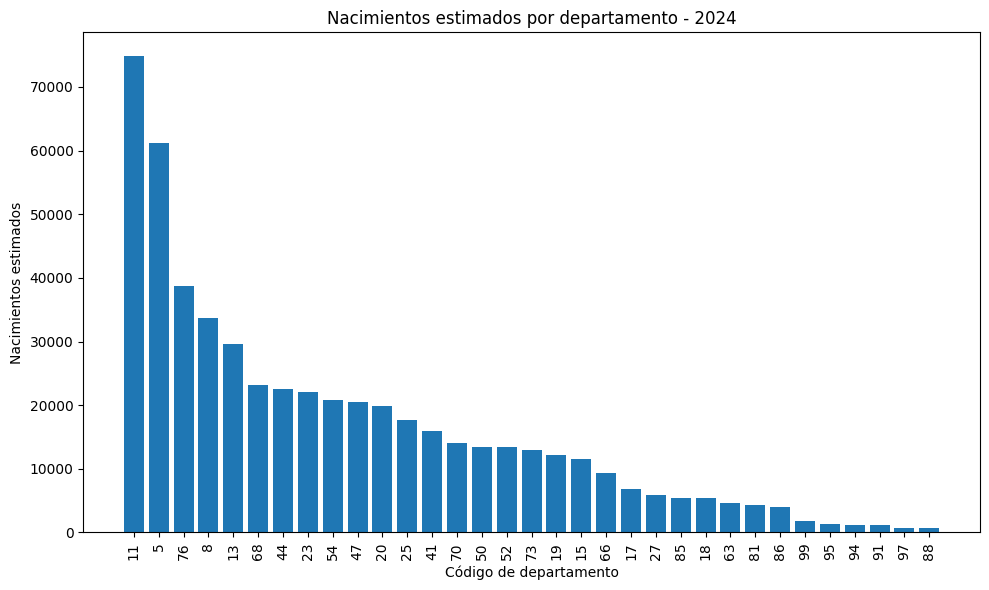

In [24]:
# === Gráfico de barras: nacimientos estimados por departamento (2024) ===
df_2024_plot = df_2024.sort_values('nacimientos_predichos', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(df_2024_plot['depto'].astype(str), df_2024_plot['nacimientos_predichos'])
plt.xticks(rotation=90)
plt.title('Nacimientos estimados por departamento - 2024')
plt.xlabel('Código de departamento')
plt.ylabel('Nacimientos estimados')
plt.tight_layout()
plt.show()

## H) Conclusiones

El modelo de Machine Learning desarrollado permitió aproximar de forma adecuada el comportamiento del número de nacimientos por departamento en Colombia. El mejor modelo seleccionado fue **Random Forest**, que para el año de prueba 2023 obtuvo un **MAE ≈ 1.518 nacimientos**, un **RMSE ≈ 2.025 nacimientos** y un **R² ≈ 0,98**. En términos relativos, el MAE representa alrededor del 10 % del promedio de nacimientos por departamento, lo que indica que el modelo comete errores moderados pero razonables frente a la magnitud de los datos y captura la mayor parte de la variabilidad observada.

Desde el punto de vista histórico, el análisis nacional mostró una **tendencia decreciente** en el número total de nacimientos entre 2020 y 2023. Se pasó de aproximadamente **629.402 nacimientos en 2020** a **515.549 en 2023**, lo que supone una reducción cercana al 18 % en cuatro años. Esta disminución se refleja de manera heterogénea entre departamentos, con algunos territorios concentrando de forma consistente los valores más altos (aquellos con mayor población) y otros manteniendo cifras considerablemente menores, lo cual es coherente con la distribución demográfica del país.

A partir del modelo entrenado con los datos de **2020–2023**, se realizó la **proyección para 2024**. El resultado global estima alrededor de **530.670 nacimientos** a nivel nacional, lo que implicaría un ligero aumento cercano al 3 % respecto a 2023. En la distribución por departamentos, los territorios con mayor peso poblacional continúan concentrando la mayoría de los nacimientos proyectados, mientras que los departamentos menos poblados mantienen valores relativamente bajos. Estas estimaciones pueden considerarse un insumo inicial para la planeación de servicios de salud materno-infantil y otras políticas públicas.

No obstante, el estudio presenta limitaciones importantes. Por una parte, solo se utilizaron **cuatro años de información** (2020–2023), lo que restringe la capacidad del modelo para capturar tendencias de largo plazo. Por otra, las variables explicativas se limitaron al **año** y al **código de departamento**, sin incorporar factores socioeconómicos, demográficos o contextuales (estructura por edad, urbanización, migración, condiciones económicas, entre otros) que podrían influir significativamente en la dinámica de los nacimientos. Además, aunque Random Forest ofrece buen desempeño, no se exploraron modelos específicamente diseñados para series de tiempo o estructuras espacio-temporales.

Como trabajo futuro, sería pertinente **ampliar la serie histórica** con más años de datos, **incorporar nuevas variables explicativas** que caractericen mejor cada territorio y evaluar **otros enfoques de modelado**, tales como modelos de series de tiempo, modelos espaciales o arquitecturas de redes neuronales. Estas extensiones podrían mejorar la capacidad predictiva, reducir el error de estimación y proporcionar insumos más robustos para la toma de decisiones en el ámbito de la planificación en salud y la formulación de políticas públicas relacionadas con los nacimientos en Colombia.
